In [1]:
import sys ###randomheader
sys.path.append('../scripts/')
from robot import *
from scipy.stats import multivariate_normal
import random #追加

In [2]:
class Particle: 
    def __init__(self, init_pose, weight):
        self.pose = init_pose
        self.weight = weight
        
    def motion_update(self, nu, omega, time, noise_rate_pdf): 
        ns = noise_rate_pdf.rvs()
        pnu = nu + ns[0]*math.sqrt(abs(nu)/time) + ns[1]*math.sqrt(abs(omega)/time)
        pomega = omega + ns[2]*math.sqrt(abs(nu)/time) + ns[3]*math.sqrt(abs(omega)/time)
        self.pose = IdealRobot.state_transition(pnu, pomega, time, self.pose)
        
    def observation_update(self, observation, envmap, distance_dev_rate, direction_dev):  #変更
        for d in observation:
            obs_pos = d[0]
            obs_id = d[1]
            
            ###パーティクルの位置と地図からランドマークの距離と方角を算出###
            pos_on_map = envmap.landmarks[obs_id].pos
            particle_suggest_pos = IdealCamera.relative_polar_pos(self.pose, pos_on_map)
            
            ###尤度の計算###
            distance_dev = distance_dev_rate*particle_suggest_pos[0]
            cov = np.diag(np.array([distance_dev**2, direction_dev**2]))
            self.weight *= multivariate_normal(mean=particle_suggest_pos, cov=cov).pdf(obs_pos)

In [3]:
class Mcl:  ###addresampling (16〜31行目)
    def __init__(self, envmap, init_pose, num, motion_noise_stds, \
                 distance_dev_rate=0.14, direction_dev=0.05):    #2行目でenvmapを追加、3行目で標準偏差を追加
        self.particles = [Particle(init_pose, 1.0/num) for i in range(num)]
        self.map = envmap  #以下3行追加
        self.distance_dev_rate = distance_dev_rate
        self.direction_dev = direction_dev

        v = motion_noise_stds
        c = np.diag([v["nn"]**2, v["no"]**2, v["on"]**2, v["oo"]**2])
        self.motion_noise_rate_pdf = multivariate_normal(cov=c)
        
    def motion_update(self, nu, omega, time):
        for p in self.particles: p.motion_update(nu, omega, time, self.motion_noise_rate_pdf)
            
    def observation_update(self, observation): #18行目で引数を追加
        for p in self.particles: p.observation_update(observation, self.map, \
                                                      self.distance_dev_rate, self.direction_dev) 
        self.resampling() #追加
            
    def resampling(self): #追加
        ws = [e.weight for e in self.particles]    # 重みのリストを作る
        
        #重みの和がゼロに丸め込まれるとサンプリングできなくなるので小さな数を足しておく
        if sum(ws) < 1e-100: ws = [e + 1e-100 for e in ws]
        
        # パーティクルのリストから、weightsのリストの重みに比例した確率で、num個選ぶ    
        ps = random.choices(self.particles, weights=ws, k=len(self.particles))  
        
        # 選んだリストからパーティクルを取り出し、重みを均一に
        self.particles = [Particle(e.pose,1.0/len(self.particles)) for e in ps]          
        
    def draw(self, ax, elems):         #次のように変更
        xs = [p.pose[0] for p in self.particles]
        ys = [p.pose[1] for p in self.particles]
        vxs = [math.cos(p.pose[2])*p.weight*len(self.particles) for p in self.particles] #重みを要素に反映
        vys = [math.sin(p.pose[2])*p.weight*len(self.particles) for p in self.particles]  #重みを要素に反映
        elems.append(ax.quiver(xs, ys, vxs, vys, \
                               angles='xy', scale_units='xy', scale=1.5, color="blue", alpha=0.5)) #変更

In [4]:
class MclAgent(Agent): 
    def __init__(self, time_interval, nu, omega, particle_pose, envmap, particle_num=100, \
                motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}): #2行目にenvmapを追加
        super().__init__(nu, omega)
        self.mcl = Mcl(envmap, particle_pose, particle_num, motion_noise_stds) #envmapを追加
        self.time_interval = time_interval
        
        self.prev_nu = 0.0
        self.prev_omega = 0.0
        
    def decision(self, observation=None): 
        self.mcl.motion_update(self.prev_nu, self.prev_omega, self.time_interval)
        self.prev_nu, self.prev_omega = self.nu, self.omega
        self.mcl.observation_update(observation)
        return self.nu, self.omega
        
    def draw(self, ax, elems):
        self.mcl.draw(ax, elems)

<IPython.core.display.Javascript object>


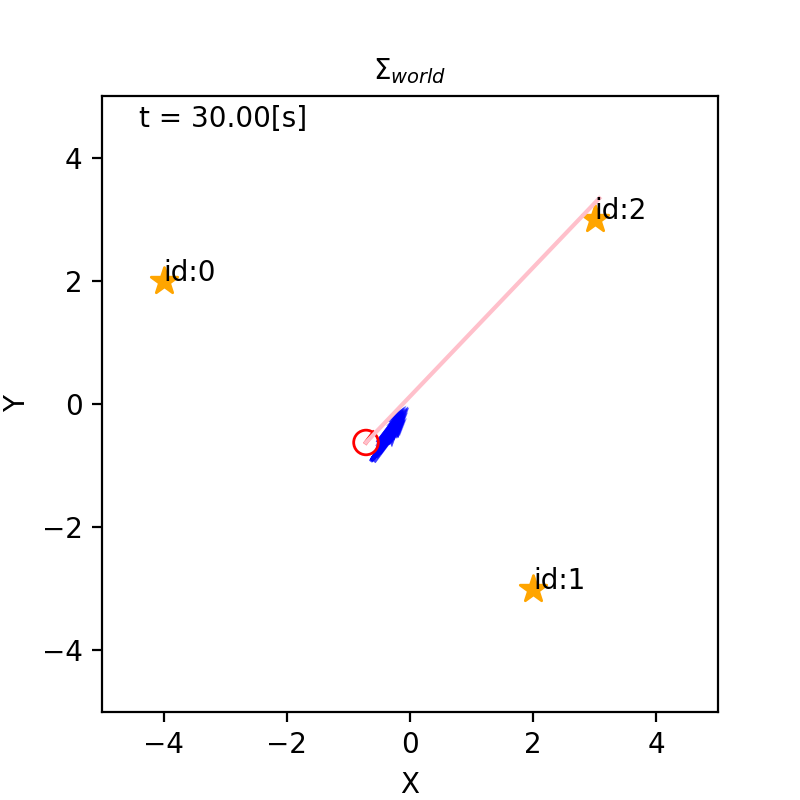

In [5]:
if __name__ == '__main__': 
    time_interval = 0.1
    world = World(30, time_interval) 

    ### 地図を生成して3つランドマークを追加 ###
    m = Map()                                  
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)          

    ### ロボットを作る ###
    circling = MclAgent(time_interval, 0.2, -10.0/180*math.pi, np.array([0, 0, 0]).T, m, particle_num=100) #地図を引数で渡す
    r = Robot(np.array([0,0,0]).T, sensor=Camera(m), agent=circling, color="red")
    world.append(r)

    world.draw()                       # アニメーションさせるとき
    #r.one_step(time_interval)  # アニメーションなしでデバッグするときhttp://localhost:8888/notebooks/section_particle_filter/mcl12.ipynb#